This experiment looks at sequences with bigger vocabularies 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import os
import sys
sys.path.append(os.getcwd())
from RNN_util import *
import numpy as np

In [2]:
# helper function

# def check_chunk_occurrence(chunk, state_trajectory):
#     # code to check for the time index on when a chunk is identified in the sequence 
#     t = [0]*len(state_trajectory)
#     idx = []
#     for i in range(0, len(state_trajectory)):
#         if state_trajectory[i:i+len(chunk)] == list(chunk):
#             t[i] = 1
#             idx.append(i)
#     return idx, t 


# def chunkmerging(vocab,state_trajectory):
#     overlap_candidates = []
#     for key in list(vocab.keys()):
#         if len(key)>=2:
#             overlap_candidates.append(key)
            
#     for c1 in overlap_candidates:
#         for c2 in overlap_candidates:
#             if c1 != c2:
#                 cat, dt, len_intersection = checkoverlap(c1, c2)
#                 if len_intersection !=0:           
#                     idx1, t1 = check_chunk_occurrence(c1, state_trajectory)
#                     idx2, t2 = check_chunk_occurrence(c2, state_trajectory)
#                     # Calculate Jaccard Index
#                     index = jaccard_index(t1, t2[dt:]+t2[:dt])# t1 happens, then t2 happens 
#                     if index>=0.8:
#                         if cat not in vocab:
#                             vocab[cat] = len(idx1)# a preliminary estimate of value
#     return vocab




# def checkoverlap(c1,c2):
#     c1 = list(c1)
#     c2 = list(c2)
#     dt = None
#     len_intersection = 0
#     c = None
#     for i in range(0, len(c1)):
#         if c1[i:]==c2[0:len(c1[i:])]:
#             len_intersection = len(c1[i:])
#             dt = i
#     c = c1[0:dt]+ c2
#     return tuple(c), dt, len_intersection



# def jaccard_index(series1, series2): # 1 perfect event overlap, 0 no event overlaps
#     # Convert to boolean arrays for bitwise operations
#     series1_bool = np.array(series1, dtype=bool)
#     series2_bool = np.array(series2, dtype=bool)
#     intersection = sum((series1_bool & series2_bool))
#     union = sum((series1_bool | series1_bool))
#     return intersection / union if union else 0




# # convert hidden unit activity on a continous time scale to symbolic 
# from sklearn.cluster import KMeans
# import numpy as np

# def learn_neural_clusters(hidden_unit_activity, n_neurons = 12,num_bins = 5):

#     # Number of bins (k)
# #     num_bins = 5 # 5 clusters for each hidden units for now

#     cluster_center_record = np.zeros([n_neurons, num_bins]) # record the cluster center for each neuron
#     symbolic_hidden_activity = []
#     for i in range(0, hidden_unit_activity.shape[0]):
#         # Example data
#         data = hidden_unit_activity[i,:].reshape([-1,1])  # 1000 data points

#         # Apply K-means clustering
#         kmeans = KMeans(n_clusters=num_bins, random_state=0, n_init = 10).fit(data)

#         # Assign each data point to the nearest cluster center (bin)
#         binned_data = kmeans.predict(data)
#         symbolic_hidden_activity.append(binned_data)

#         cluster_center_record[i,:] = kmeans.cluster_centers_[:,0]   
        
#     return cluster_center_record, symbolic_hidden_activity



In [4]:
# RNN Model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) # update hidden 
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined) # nn.Linear(input_size + hidden_size, hidden_size)
        output = self.i2o(combined) # nn.Linear(input_size + hidden_size, output_size)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


# def train_rnn(rnn, sequence, n_iters = 160,chunk_len = 200, learn = True):
#     # Loss function and optimizer
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(rnn.parameters(), lr=0.005)

#     # Training
#     print_every = 50
# #     n_iters = 160
# #     chunk_len = 200  # Length of a chunk of the sequence used for one training batch
#     hidden_states = []
#     hidden_seq = []
    
#     for iter in range(1, n_iters + 1):
#         rnn.zero_grad()
#         loss = 0
#         hidden = rnn.initHidden()

#         # Random start index to slice the sequence
#         start_index = torch.randint(len(sequence) - chunk_len, (1,)).item()
#         end_index = start_index + chunk_len + 1
#         chunk = sequence[start_index:end_index]

#         # Prepare input and target sequences
#         acc = 0
#         for i in range(chunk_len):
#             input_char = chunk[i]
#             target_char = chunk[i + 1]
#             input_tensor = torch.nn.functional.one_hot(torch.tensor([char_to_int[input_char]], dtype=torch.long), num_classes=input_size).type(torch.float)
#             target_tensor = torch.tensor([char_to_int[target_char]], dtype=torch.long)
            
#             output, hidden = rnn(input_tensor, hidden)
#             predict_char = int_to_char[output.argmax(1).item()]
#             if predict_char == target_char: acc = acc + 1
#             loss += criterion(output, target_tensor)
#             if iter == 160:
#                 hidden_states.append(hidden.detach().numpy())  # detach from the graph and convert to numpy
#                 hidden_seq.append(input_char)
#         acc = acc/chunk_len
        
#         if learn == True: 
#             loss.backward()
#             optimizer.step()

#         if iter % print_every == 0:
#             print(f'Iteration {iter} loss: {loss.item() / chunk_len} acc: {acc}')
            
            
#     return rnn, hidden_states, hidden_seq

In [11]:

import torch
import torch.nn as nn
import torch.optim as optim

# Model parameters
hidden_size = 12
input_size = len(char_to_int)
output_size = len(char_to_int)
char_to_int = {char: i for i, char in enumerate('ABCDE')}
int_to_char = {i: char for i, char in enumerate('ABCDE')}

rnn = RNN(input_size, hidden_size, output_size) 

# hidden = rnn.initHidden()
# input_char = 'A'
# for i in range(6):
#     input_tensor = torch.nn.functional.one_hot(torch.tensor([char_to_int[input_char]], dtype=torch.long), num_classes=input_size).type(torch.float)
#     # perturbation here 
#     output, hidden = rnn(input_tensor, hidden)
#     predict_char = int_to_char[output.argmax(1).item()]
#     print('previous char ', input_char,' prediction char ', int_to_char[output.argmax(1).item()])
#     input_char = predict_char

NameError: name 'sequence' is not defined

# Check the Gradient of nested compositionality structure, and check the internal state of NN from learning sequences with such gradients 

In [12]:
# Data preparation
import numpy as np
def generate_sequence_with_hierarchy(n_h = 20): 
    '''n_h: every hierarchy is a new iteration of random combination '''
    # generate vocabulatory up to the nth hierarchical level
    vocab = ['A','B','C','D'] # initialize a seed vocab 
    for h in range(n_h):
        newword = ''.join([np.random.choice(vocab),np.random.choice(vocab)]) # every iteration is a combination of existing vocab 
        vocab.append(newword)
    vocab = vocab + ['E'] # E denotes an empty symbol

    alpha = np.ones(len(vocab)-1) # Concentration parameters (all set to 1 for a flat Dirichlet distribution)
    probabilities = sorted(np.random.dirichlet(alpha))# Sample a probability vector from the Dirichlet distribution, sort from low to high
    probabilities = [0.2*p for p in probabilities] + [0.8]

    l = 100000# length of the sequence 
    sequence = ''.join(np.random.choice(vocab, size=l, replace=True, p=probabilities))
    return sequence[:l], vocab


In [7]:
# def parse_state_trajectory(state_trajectory, vocab, input_seq):
#     '''vocab: dictionary with chunks and their frequencies'''
#     maxkey = sorted(vocab.keys(), key=lambda x: len(x), reverse = True)
#     trajcopy = []
#     inputparse = []
#     i = 0    
#     while i<len(state_trajectory):
#         match = False
#         for key in maxkey:
#             keylen = len(list(key))
#             if i+keylen<len(state_trajectory):
#                 if state_trajectory[i:i+keylen] == list(key):
#                     trajcopy.append(tuple(state_trajectory[i:i+keylen]))
#                     inputparse.append(tuple(input_seq[i:i+keylen]))
#                     i = i + keylen
#                     match = True
#             if match:break
#         if match==False:
#             trajcopy.append(tuple([state_trajectory[i]]))
#             inputparse.append(tuple(input_seq[i]))
#             i = i + 1
#     return trajcopy, inputparse

# def learn_chunks(symbolic_hidden_activity, sequence, n_new_chunks = 10, n_iter = 60, freq_threshold = 5):
#     # returns traj_copy:
#     # [('301442142110',),
#     #  ('314401333111',),
#     #  ('011331041042',),
#     #  ('400313144220',),
#     #  ('020011111020', '000011111000'),]
#     # returns input_parse:
#     # [('C',),
#     #  ('D',),
#     #  ('E',),
#     #  ('E',),
#     #  ('E', 'E'),
#     #  ('E',),
#     #  ('E',),
#     #  ('A', 'B'),
#     from collections import Counter
#     # chunks of states, how to find them 
#     state_trajectory = []
#     for i in range(0,symbolic_hidden_activity.shape[1]):
#         state = ''.join(str(num) for num in symbolic_hidden_activity[:,i])
#         state_trajectory.append(state)
#     vocab = Counter(state_trajectory)
#     initial_vocab = vocab.copy()

#     # identify null state and exclude them for further chunking process
#     atomictraj =[tuple([item]) for item in state_trajectory] # atomic states
#     vocab = dict(Counter(atomictraj))
#     null_state, freq = sorted(vocab.items(), key=lambda item: item[1], reverse=True)[0] # take the most popular mode as the null mode

#     trajcopy =[tuple([item]) for item in state_trajectory]
# #     print(len(trajcopy), len(sequence)) # copy of the parsed trajectory 
#     for _ in range(0,n_iter):
#         vocab = dict(Counter(trajcopy))
#         paired_freq = Counter(zip(trajcopy[:-1], trajcopy[1:])).most_common(n_new_chunks)
#     #     for a,b in paired_freq:print(a,b)
#         merged_list = [(char_tuple[0]+char_tuple[1], freq) for char_tuple, freq in paired_freq if freq >= freq_threshold and char_tuple[0]!=null_state and char_tuple[1]!=null_state]
#         merged_dict = {}
#         for key, value in merged_list:
#             merged_dict[key] = value
#         # add a mechanism that checks for overlaps amongst vocabs 
#         vocab.update(merged_dict)
#         vocab = chunkmerging(vocab,state_trajectory)
#         trajcopy,input_parse = parse_state_trajectory(state_trajectory, vocab, sequence)
#     return trajcopy, input_parse, vocab, initial_vocab

In [13]:
def get_gtseql(educated_hidden_seq,vocabulary):
    gtseql = 0
    i = 0
    while i <len(educated_hidden_seq):
        maxmatch = 0
        maxword = None
        for word in vocabulary:
            if ''.join(educated_hidden_seq[i:i+len(word)]) == word and len(word)>=maxmatch:
                    maxword = word
        i = i + len(maxword)
        gtseql = gtseql + 1
    return gtseql

In [ ]:
from collections import Counter 
n_hierarchy = np.arange(0, 40, 5)  # 10 different hierarchy levels
n_iter = 10  # 10 iterations for each hierarchy level
hidden_size = 12
input_size = len(char_to_int)
output_size = len(char_to_int)
chunk_len = 5000
n_it = 300 # training iteration

gtseql_dict = {str(level): {f'iteration_{i}': None for i in range(n_iter)} for level in n_hierarchy}# ground truth sequence length
data_dict = {str(level): {f'iteration_{i}': None for i in range(n_iter)} for level in n_hierarchy}
vocab_dict = {str(level): {f'iteration_{i}': None for i in range(n_iter)} for level in n_hierarchy}
initial_vocab_dict = {str(level): {f'iteration_{i}': None for i in range(n_iter)} for level in n_hierarchy}
parsed_vocab_size_dict = {str(level): {f'iteration_{i}': None for i in range(n_iter)} for level in n_hierarchy}
filtered_vocab_size_dict = {str(level): {f'iteration_{i}': None for i in range(n_iter)} for level in n_hierarchy}
# Example: Store data at each hierarchy level and iteration
for level in n_hierarchy:
    for i in range(n_iter):
        print('level is ', level)
        # Example data: store a random value (replace this with your actual data)
        sequence, vocabulary = generate_sequence_with_hierarchy(n_h = level)
        educated_rnn = RNN(input_size, hidden_size, output_size) 
        educated_NN, educated_hidden_states, educated_hidden_seq,_,_,_ = train_rnn(educated_rnn, sequence,input_size,char_to_int, int_to_char, n_iters = n_it, chunk_len = chunk_len, learn = True)
        # educated_NN, educated_hidden_states, educated_hidden_seq  = train_rnn(educated_rnn, sequence, n_iters = n_it, chunk_len = chunk_len, learn = True)
        gtseql = get_gtseql(educated_hidden_seq, vocabulary)# ground truth sequence parsing length 
        educated_hidden_states = np.array(educated_hidden_states)
        educated_hidden_unit_activity = educated_hidden_states[:, 0, :].T
        educated_cluster_center_record, educated_symbolic_hidden_activity = learn_neural_clusters(educated_hidden_unit_activity, n_neurons = hidden_size,num_bins = 3)
        educated_symbolic_hidden_activity = np.array(educated_symbolic_hidden_activity) # each label in each neuron is independent
        educated_trajcopy, educated_input_parse, vocab, educated_initial_vocab_size = learn_chunks(educated_symbolic_hidden_activity,educated_hidden_seq)
        
        gtseql_dict[str(level)][f'iteration_{i}'] = gtseql
        data_dict[str(level)][f'iteration_{i}'] = len(educated_trajcopy)
        vocab_dict[str(level)][f'iteration_{i}'] = len(vocab)
        initial_vocab_dict[str(level)][f'iteration_{i}'] = len(educated_initial_vocab_size)
        parsed_vocab_size_dict[str(level)][f'iteration_{i}'] = len(Counter(educated_trajcopy))
        filtered_vocab = {key: value for key, value in vocab.items() if value > 5}
        filtered_vocab_size_dict[str(level)][f'iteration_{i}'] = len(filtered_vocab)
        

level is  0
Iteration 100 loss: 0.720737744140625 acc: 0.8004
Iteration 200 loss: 0.708846484375 acc: 0.8058
Iteration 300 loss: 0.73149853515625 acc: 0.796
level is  0
Iteration 100 loss: 0.737942724609375 acc: 0.8006
Iteration 200 loss: 0.74105908203125 acc: 0.8012
Iteration 300 loss: 0.74437978515625 acc: 0.798
level is  0
Iteration 100 loss: 0.697355322265625 acc: 0.7986
Iteration 200 loss: 0.69388876953125 acc: 0.7972
Iteration 300 loss: 0.68707294921875 acc: 0.803
level is  0
Iteration 100 loss: 0.74340927734375 acc: 0.8066
Iteration 200 loss: 0.7594369140625 acc: 0.7996
Iteration 300 loss: 0.754131884765625 acc: 0.8008
level is  0
Iteration 100 loss: 0.76815537109375 acc: 0.797


In [96]:
import json
with open('hierarchy_gradient_n_chunk.json', 'w') as json_file:
    json.dump(data_dict, json_file)
with open('hierarchy_gradient_n_chunk_vocab.json', 'w') as json_file:
    json.dump(vocab_dict, json_file)
with open('hierarchy_gradient_n_initial_vocab.json', 'w') as json_file:
    json.dump(initial_vocab_dict, json_file)
with open('parsed_vocab_size_dict.json', 'w') as json_file:
    json.dump(parsed_vocab_size_dict, json_file)
with open('filtered_vocab_size_dict.json', 'w') as json_file:
    json.dump(filtered_vocab_size_dict, json_file)
with open('gtseql_dict.json', 'w') as json_file:
    json.dump(gtseql_dict, json_file)

Dictionary saved to data.json
Dictionary saved to data.json
Dictionary saved to data.json
Dictionary saved to data.json
Dictionary saved to data.json
Dictionary saved to data.json


In [97]:
data_dict

{'0': {'iteration_0': 2577,
  'iteration_1': 2443,
  'iteration_2': 2632,
  'iteration_3': 2338,
  'iteration_4': 2447,
  'iteration_5': 2292,
  'iteration_6': 2262,
  'iteration_7': 2443,
  'iteration_8': 2487,
  'iteration_9': 2547},
 '5': {'iteration_0': 2306,
  'iteration_1': 2613,
  'iteration_2': 2253,
  'iteration_3': 2321,
  'iteration_4': 1902,
  'iteration_5': 2370,
  'iteration_6': 2141,
  'iteration_7': 2147,
  'iteration_8': 2061,
  'iteration_9': 2302},
 '10': {'iteration_0': 2191,
  'iteration_1': 2070,
  'iteration_2': 2098,
  'iteration_3': 2323,
  'iteration_4': 2095,
  'iteration_5': 2280,
  'iteration_6': 2896,
  'iteration_7': 2508,
  'iteration_8': 2320,
  'iteration_9': 1923},
 '15': {'iteration_0': 2502,
  'iteration_1': 2422,
  'iteration_2': 1860,
  'iteration_3': 2083,
  'iteration_4': 2009,
  'iteration_5': 2283,
  'iteration_6': 2084,
  'iteration_7': 2063,
  'iteration_8': 2107,
  'iteration_9': 2221},
 '20': {'iteration_0': 2501,
  'iteration_1': 2461,
  

In [98]:
vocab_dict

{'0': {'iteration_0': 156,
  'iteration_1': 161,
  'iteration_2': 103,
  'iteration_3': 116,
  'iteration_4': 119,
  'iteration_5': 119,
  'iteration_6': 92,
  'iteration_7': 207,
  'iteration_8': 185,
  'iteration_9': 126},
 '5': {'iteration_0': 269,
  'iteration_1': 174,
  'iteration_2': 196,
  'iteration_3': 186,
  'iteration_4': 174,
  'iteration_5': 115,
  'iteration_6': 59,
  'iteration_7': 97,
  'iteration_8': 55,
  'iteration_9': 118},
 '10': {'iteration_0': 234,
  'iteration_1': 244,
  'iteration_2': 225,
  'iteration_3': 350,
  'iteration_4': 386,
  'iteration_5': 338,
  'iteration_6': 607,
  'iteration_7': 371,
  'iteration_8': 656,
  'iteration_9': 290},
 '15': {'iteration_0': 447,
  'iteration_1': 178,
  'iteration_2': 413,
  'iteration_3': 413,
  'iteration_4': 279,
  'iteration_5': 174,
  'iteration_6': 410,
  'iteration_7': 462,
  'iteration_8': 387,
  'iteration_9': 355},
 '20': {'iteration_0': 577,
  'iteration_1': 416,
  'iteration_2': 539,
  'iteration_3': 303,
  'i

In [99]:
initial_vocab_dict

{'0': {'iteration_0': 147,
  'iteration_1': 148,
  'iteration_2': 99,
  'iteration_3': 107,
  'iteration_4': 108,
  'iteration_5': 109,
  'iteration_6': 79,
  'iteration_7': 194,
  'iteration_8': 173,
  'iteration_9': 120},
 '5': {'iteration_0': 248,
  'iteration_1': 166,
  'iteration_2': 182,
  'iteration_3': 169,
  'iteration_4': 150,
  'iteration_5': 104,
  'iteration_6': 49,
  'iteration_7': 82,
  'iteration_8': 42,
  'iteration_9': 103},
 '10': {'iteration_0': 218,
  'iteration_1': 217,
  'iteration_2': 200,
  'iteration_3': 326,
  'iteration_4': 353,
  'iteration_5': 308,
  'iteration_6': 603,
  'iteration_7': 351,
  'iteration_8': 581,
  'iteration_9': 255},
 '15': {'iteration_0': 425,
  'iteration_1': 167,
  'iteration_2': 369,
  'iteration_3': 378,
  'iteration_4': 240,
  'iteration_5': 155,
  'iteration_6': 376,
  'iteration_7': 424,
  'iteration_8': 358,
  'iteration_9': 323},
 '20': {'iteration_0': 552,
  'iteration_1': 388,
  'iteration_2': 523,
  'iteration_3': 262,
  'it

No handles with labels found to put in legend.


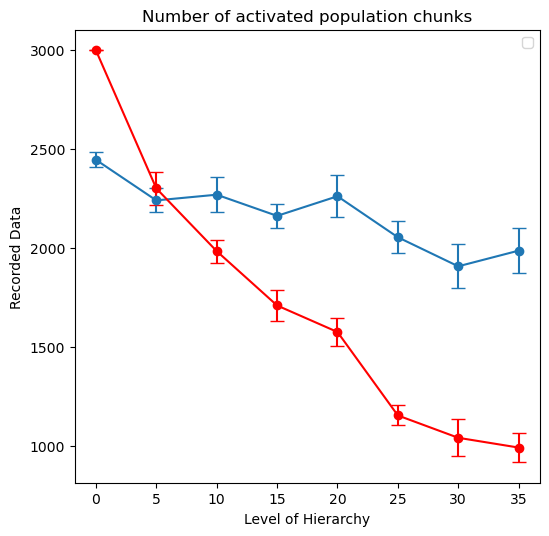

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Load the dictionary from the JSON file
with open('hierarchy_gradient_n_chunk.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert keys to integers (if needed)
loaded_data = {int(k): v for k, v in loaded_data.items()}

mean_values = []
sem_values = []
hiearchies = []

# Prepare data for plotting
plt.figure(figsize=(6, 6), dpi= 100)

for level, iterations in loaded_data.items():
    hiearchies.append(int(level))
    mean_values.append(np.mean(list(iterations.values())))
    sem_values.append(stats.sem(list(iterations.values())))

# Plot the mean line
plt.errorbar(hiearchies, mean_values, yerr=sem_values, fmt='-o', capsize=5)


# Load the dictionary from the JSON file
with open('gtseql_dict.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert keys to integers (if needed)
loaded_data = {int(k): v for k, v in loaded_data.items()}

mean_values = []
sem_values = []
hiearchies = []

for level, iterations in loaded_data.items():
    hiearchies.append(int(level))
    mean_values.append(np.mean(list(iterations.values())))
    sem_values.append(stats.sem(list(iterations.values())))

# Plot the mean line
plt.errorbar(hiearchies, mean_values, yerr=sem_values, fmt='-o', capsize=5, color = 'r')



# Add shaded area representing the standard deviation
# plt.fill_between(list(iterations.keys), mean_values - std_dev_values, mean_values + std_dev_values, alpha=0.2)


# Customize the plot
plt.xlabel('Level of Hierarchy')
plt.ylabel('Recorded Data')
plt.title('Number of activated population chunks')
plt.legend()
plt.grid(False)

# Display the plot
plt.show()


No handles with labels found to put in legend.


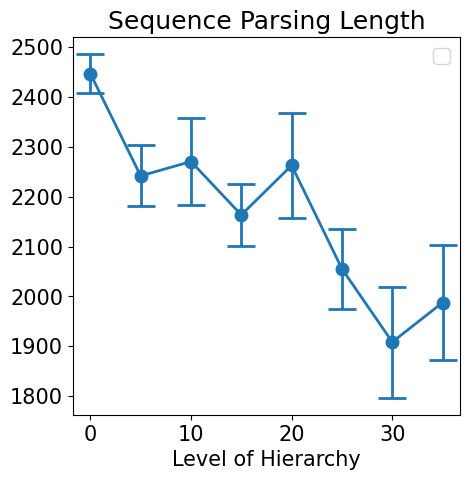

In [18]:
import json
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 15})


# Load the dictionary from the JSON file
with open('hierarchy_gradient_n_chunk.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert keys to integers (if needed)
loaded_data = {int(k): v for k, v in loaded_data.items()}

mean_values = []
sem_values = []
hiearchies = []

# Prepare data for plotting
plt.figure(figsize=(5, 5), dpi= 100)

for level, iterations in loaded_data.items():
    hiearchies.append(int(level))
    mean_values.append(np.mean(list(iterations.values())))
    sem_values.append(stats.sem(list(iterations.values())))

# Plot the mean line
plt.errorbar(hiearchies, mean_values, yerr=sem_values, 
             fmt='-o',
             capsize=10,        # Size of error bar caps
    linewidth=2,       # Thickness of the line
    markersize=8,      # Size of the dot markers
    markeredgewidth=2)  # Thickness of marker edges)





# Load the dictionary from the JSON file
with open('gtseql_dict.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert keys to integers (if needed)
loaded_data = {int(k): v for k, v in loaded_data.items()}

mean_values = []
sem_values = []
hiearchies = []

for level, iterations in loaded_data.items():
    hiearchies.append(int(level))
    mean_values.append(np.mean(list(iterations.values())))
    sem_values.append(stats.sem(list(iterations.values())))

# Plot the mean line
# plt.errorbar(hiearchies, mean_values, yerr=sem_values, fmt='-o', capsize=5, color = 'r')



# Add shaded area representing the standard deviation
# plt.fill_between(list(iterations.keys), mean_values - std_dev_values, mean_values + std_dev_values, alpha=0.2)


# Customize the plot
plt.xlabel('Level of Hierarchy')
plt.ylabel('')
plt.title('Sequence Parsing Length')
plt.legend()
plt.grid(False)

# Display the plot
plt.show()


No handles with labels found to put in legend.


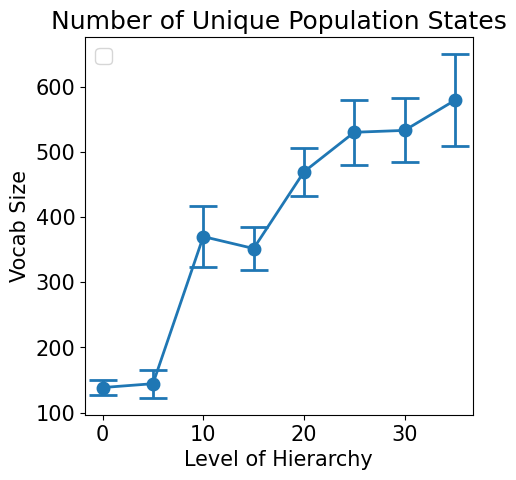

In [20]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load the dictionary from the JSON file
with open('hierarchy_gradient_n_chunk_vocab.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert keys to integers (if needed)
loaded_data = {int(k): v for k, v in loaded_data.items()}

mean_values = []
sem_values = []
hiearchies = []

# Prepare data for plotting
plt.figure(figsize=(5, 5), dpi = 100)

# Loop over each hierarchy level
for level, iterations in loaded_data.items():
    # Extract iteration numbers and corresponding data points
    hiearchies.append(int(level))

    # Calculate the mean and standard deviation
    mean_values.append(np.mean(list(iterations.values())))
    sem_values.append(stats.sem(list(iterations.values())))

# Plot the mean line
plt.errorbar(hiearchies, mean_values, yerr=sem_values,
fmt='-o',capsize=10,        # Size of error bar caps
    linewidth=2,       # Thickness of the line
    markersize=8,      # Size of the dot markers
    markeredgewidth=2)  # Thickness of marker edges)
             
# Add shaded area representing the standard deviation
# plt.fill_between(list(iterations.keys), mean_values - std_dev_values, mean_values + std_dev_values, alpha=0.2)

# Customize the plot
plt.xlabel('Level of Hierarchy')
plt.ylabel('Vocab Size')
plt.title('Number of Unique Population States')
plt.legend()
plt.grid(False)

# Display the plot
plt.show()


In [105]:
for level, iterations in loaded_data.items():
    print(level, iterations)

0 {'iteration_0': 156, 'iteration_1': 161, 'iteration_2': 103, 'iteration_3': 116, 'iteration_4': 119, 'iteration_5': 119, 'iteration_6': 92, 'iteration_7': 207, 'iteration_8': 185, 'iteration_9': 126}
5 {'iteration_0': 269, 'iteration_1': 174, 'iteration_2': 196, 'iteration_3': 186, 'iteration_4': 174, 'iteration_5': 115, 'iteration_6': 59, 'iteration_7': 97, 'iteration_8': 55, 'iteration_9': 118}
10 {'iteration_0': 234, 'iteration_1': 244, 'iteration_2': 225, 'iteration_3': 350, 'iteration_4': 386, 'iteration_5': 338, 'iteration_6': 607, 'iteration_7': 371, 'iteration_8': 656, 'iteration_9': 290}
15 {'iteration_0': 447, 'iteration_1': 178, 'iteration_2': 413, 'iteration_3': 413, 'iteration_4': 279, 'iteration_5': 174, 'iteration_6': 410, 'iteration_7': 462, 'iteration_8': 387, 'iteration_9': 355}
20 {'iteration_0': 577, 'iteration_1': 416, 'iteration_2': 539, 'iteration_3': 303, 'iteration_4': 460, 'iteration_5': 429, 'iteration_6': 595, 'iteration_7': 490, 'iteration_8': 273, 'itera

No handles with labels found to put in legend.


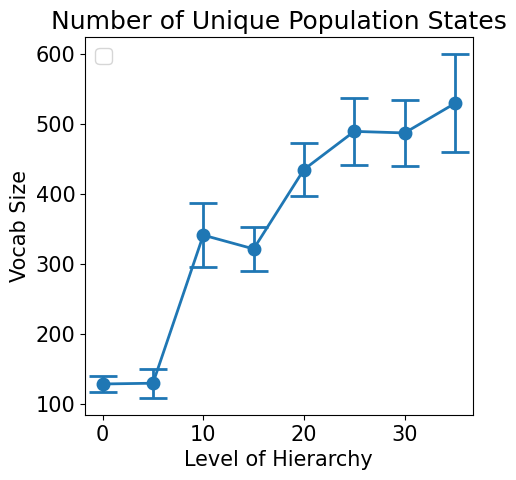

In [21]:
# vocab_dict
from scipy import stats
import json
import numpy as np
import matplotlib.pyplot as plt

# Load the dictionary from the JSON file
with open('hierarchy_gradient_n_initial_vocab.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert keys to integers (if needed)
loaded_data = {int(k): v for k, v in loaded_data.items()}

mean_values = []
sem_values = []
hiearchies = []

# Prepare data for plotting
plt.figure(figsize=(5, 5), dpi = 100)

# Loop over each hierarchy level
for level, iterations in loaded_data.items():
#     print(level, iterations)
    # Extract iteration numbers and corresponding data points
    hiearchies.append(int(level))
    mean_values.append(np.mean(list(iterations.values())))
    sem_values.append(stats.sem(list(iterations.values())))

# Plot the mean line
plt.errorbar(hiearchies, mean_values, yerr=sem_values,
fmt='-o',capsize=10,        # Size of error bar caps
    linewidth=2,       # Thickness of the line
    markersize=8,      # Size of the dot markers
    markeredgewidth=2)  # Thickness of marker edges)
             
# Customize the plot
plt.xlabel('Level of Hierarchy')
plt.ylabel('Vocab Size')
plt.title('Number of Unique Population States')
plt.legend()
plt.grid(False)

# Display the plot
plt.show()


No handles with labels found to put in legend.


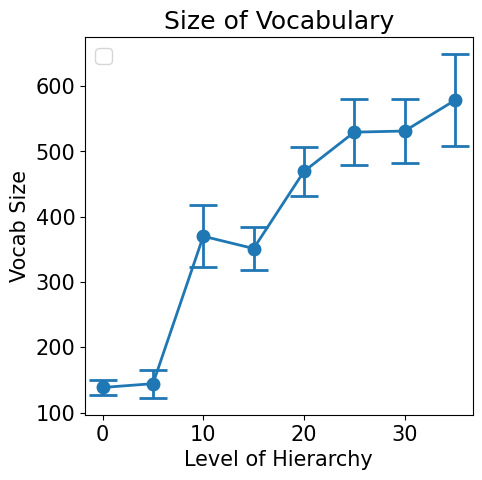

In [22]:
# Load the dictionary from the JSON file
with open('parsed_vocab_size_dict.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert keys to integers (if needed)
loaded_data = {int(k): v for k, v in loaded_data.items()}

mean_values = []
sem_values = []
hiearchies = []

# Prepare data for plotting
plt.figure(figsize=(5, 5), dpi = 100)

# Loop over each hierarchy level
for level, iterations in loaded_data.items():
#     print(level, iterations)
    # Extract iteration numbers and corresponding data points
    hiearchies.append(int(level))
    mean_values.append(np.mean(list(iterations.values())))
    sem_values.append(stats.sem(list(iterations.values())))

# Plot the mean line
plt.errorbar(hiearchies, mean_values, yerr=sem_values,
             fmt='-o',capsize=10,        # Size of error bar caps
    linewidth=2,       # Thickness of the line
    markersize=8,      # Size of the dot markers
    markeredgewidth=2)  # Thickness of marker edges)
             
# Customize the plot
plt.xlabel('Level of Hierarchy')
plt.ylabel('Vocab Size')
plt.title('Size of Vocabulary')
plt.legend()
plt.grid(False)

# Display the plot
plt.show()



No handles with labels found to put in legend.


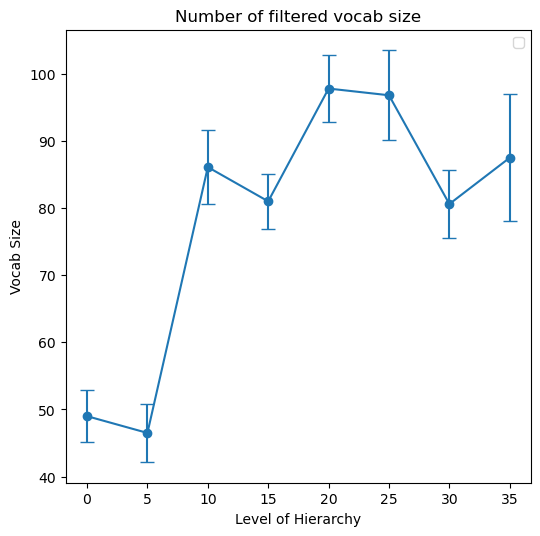

In [109]:

# Load the dictionary from the JSON file
with open('filtered_vocab_size_dict.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert keys to integers (if needed)
loaded_data = {int(k): v for k, v in loaded_data.items()}

mean_values = []
sem_values = []
hiearchies = []

# Prepare data for plotting
plt.figure(figsize=(6, 6), dpi = 100)

# Loop over each hierarchy level
for level, iterations in loaded_data.items():
#     print(level, iterations)
    # Extract iteration numbers and corresponding data points
    hiearchies.append(int(level))
    mean_values.append(np.mean(list(iterations.values())))
    sem_values.append(stats.sem(list(iterations.values())))

# Plot the mean line
plt.errorbar(hiearchies, mean_values, yerr=sem_values, fmt='-o', capsize=5)

# Customize the plot
plt.xlabel('Level of Hierarchy')
plt.ylabel('Vocab Size')
plt.title('Number of filtered vocab size')
plt.legend()
plt.grid(False)

# Display the plot
plt.show()
